# Exploratory Data Analysis of 2018 & 2019 Movies 
Clare Blessen & Melissa Munz

Using data webscraped from IMDB and called from an API.

In [4]:
#instantiate cursor and load libraries
import json
import pandas as pd
import requests
import mysql.connector
import config
import time
import requests
from bs4 import BeautifulSoup as BS

In [5]:
#specify database for connection
db = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.password,
    database = "Movies")

cursor = db.cursor()

In [3]:
#create database
from mysql.connector import errorcode
db_name = 'Movies'

def create_database(cursor, database):
    try:
        cursor.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)

We now get the first page of IMDB list of top grossing movies (2018/2019):

In [5]:
page1 = requests.get('https://www.imdb.com/search/title/?release_date=2019-01-01,2019-10-31&sort=boxoffice_gross_us,desc&start=251&ref_=adv_nxt')
soup1 = BS(page1.content, 'html.parser')
soup1.prettify()
info1 = soup1.find_all(id = 'main')
movie1 = info1[0].find_all(class_='lister-item mode-advanced')

# Webscraping IMDB data

We define functions to webscrape the critic scores, IMDB ids, titles, audience scores, release year, and gross revenue.

In [5]:
#scrape critic scores
def get_score(movie):
        metascores = []
        for score in movie:
            metascore1 = score.find(class_="metascore")
            if metascore1 == None:
                metascore = 'Null'
                metascores.append(metascore)
            else:
                metascores.append(int(metascore1.get_text(strip=True)))
        return metascores


In [6]:
#scrape IMDB ids
def find_fk(movie):
    ids = []
    for m in movie:
        id = m.find (class_="starBarWidget")['id']
        ids.append(id)
    return ids


In [7]:
#scrape titles
def get_titles(movie):

    titles = []
    for one in movie:
        title = one.find('img')['alt']
        titles.append(title) 
    return titles


In [8]:
#scrape audience scores
def get_stars(movie):
    stars = []
    for one in movie:
        try:
            stars.append(float(one.find(class_='inline-block ratings-imdb-rating')['data-value']))
        except:
            stars.append('Null')
    return stars


In [9]:
#scrape release year
def get_year(movie):
    
    years = []
    for one in movie:
        try:
            year = one.find(class_="lister-item-year text-muted unbold").get_text()
            parsed_year = year[-5:-1]
            years.append(int(parsed_year))
        except:
            years.append(2019)
    return years


In [10]:
#scrape genre
def get_genre(movie):
    genres = []
    for m in movie:
        genre = m.find(class_='genre')
        try:
            genre1 = str.split(genre.get_text(strip=True), sep = ',')[0]
        except:
            genre1 = genre
        genres.append(genre1)
    return genres


In [11]:
#scrape gross revenue
def get_gross(movie):
    gross_list = []
    
    for m in movie:
        gross = m.find(class_='sort-num_votes-visible')
        parsed_gross = gross.get_text(strip=True)
        parsed_gross2 = str.split(parsed_gross, sep='|')
        if 'Gross' in parsed_gross2[0]:
            parsed_gross2 = parsed_gross2[0]
            parsed_gross3 = str.split(parsed_gross2, sep=':')
            parsed_gross4 = str.split(parsed_gross3[1], sep='.')[0]
            final_gross = str.split(parsed_gross4, sep='$')[1]
            gross_list.append(int(final_gross))

        else:
            try:       
                parsed_gross3 = str.split(parsed_gross2[1], sep=':')
                parsed_gross4 = str.split(parsed_gross3[1], sep='.')[0]
                final_gross = str.split(parsed_gross4, sep='$')[1]
                gross_list.append(int(final_gross))
            except: 
                gross_list.append(0)
    
    return gross_list


We're inserting our IMDB data into a MySQL table by first converting it to a dataframe:

In [1]:
#create table
DB_NAME = 'Movies'

create_query = """
      CREATE TABLE imdb_movies
    (
      imdb_id varchar(24),
      title varchar(50),
      year INT(4),
      star_rating FLOAT(3),
      metascore INT(5),
      gross INT(5),
      genre varchar(30),
      CONSTRAINT primary_key PRIMARY KEY(imdb_id)
      )
    """



In [12]:
#make into DF
def make_df(movie):
    all_movies_dataframe = pd.DataFrame({
        "imdb_id": find_fk(movie),
        "title": get_titles(movie),
        "year": get_year(movie),
        "star_rating": get_stars(movie),
        "metascore": get_score(movie),
        "gross": get_gross(movie),
        "genre": get_genre(movie)
    })
    return all_movies_dataframe


In [ ]:
#uses DF to insert into mySQL
def insert_movies(dataframe):
    all_movies_tuples = list(dataframe.itertuples(index=False, name=None))
    insert_statement = """INSERT INTO imdb_movies (imdb_id, title, year, star_rating, metascore, gross, genre) 
            VALUES (%s, %s, %s, %s, %s, %s, %s);"""
    for movie in all_movies_tuples:
        
        cursor.execute(insert_statement, movie)
        print(movie)
    
#     cursor.executemany(insert_statement, all_movies_tuples)
    db.commit()


In [ ]:
#while loop to run the above process for pages 2-10
var = 51
while var < 501: 
    page = requests.get(f"https://www.imdb.com/search/title/?release_date=2019-01-01,2019-10-31&sort=boxoffice_gross_us,desc&start={var}&ref_=adv_nxt")
    soup = BS(page.content, 'html.parser')
    soup.prettify()
    info = soup.find_all(id = 'main')
    movie = info[0].find_all(class_='lister-item mode-advanced')
    movie_df = make_df(movie)
    insert_movies(movie_df)
    var +=50


# MovieDB API Data

We execute a SQL query for the IMDB IDs in order to use these as a search term in the MovieDB API:

In [6]:
#query list of IMDB ids
cursor = db.cursor()

df = cursor.execute("""SELECT imdb_id FROM Movies.imdb_movies2;""")

df = pd.DataFrame(cursor.fetchall())

df.columns = [x[0] for x in cursor.description]

list_of_ids = df.values.tolist()

list_of_imdb_ids = [val[0] for val in list_of_ids]


In [7]:
#get MovieDB data based on IMDB IDs
api_key = '0bf0d1d80e2ab08ed768c022e7f27155'
all_info = []
for id_ in list_of_imdb_ids:
    find_external_id = requests.get(f'https://api.themoviedb.org/3/find/{id_}?api_key=0bf0d1d80e2ab08ed768c022e7f27155&language=en-US&external_source=imdb_id').json()
    find_external_id['imdb_id']=id_
    all_info.append(find_external_id)


KeyboardInterrupt: 

In [ ]:
#create table for MovieDB data
DB_NAME = 'Movies'
create_query = """
      CREATE TABLE md_movies
    (
      imdb_id varchar(24),
      title varchar(50),
      release_date INT(4),
      overview varchar(50),
      FOREIGN KEY (imdb_id) REFERENCES imdb_movies2(imdb_id),
      ID INT AUTO_INCREMENT PRIMARY KEY
      )
    """
# cursor.execute(create_query)

We defined functions to parse the necessary data from MovieDB and turn it into a dataframe.

In [ ]:
#parse release date from MovieDB
def get_release_date(all_info):
    release_dates = []
    for movie in all_info:
        try:
            info = movie['movie_results'][0]
            release_date = info['release_date']
            release_dates.append(release_date)
        except:
            release_date = 'Null'
            release_dates.append(release_date)
    return release_dates

In [ ]:
#parse overview from MovieDB
def get_overview(all_info):
    overviews = []
    for movie in all_info:
        try:
            info = movie['movie_results'][0]
            overview = info['overview']
            overviews.append(overview)
        except:
            overview = 'Null'
            overviews.append(overview)
    return overviews


In [ ]:
#parse title from MovieDB
def get_title(all_info):
    titles = []
    for movie in all_info:
        try:
            info = movie['movie_results'][0]
            title = info['original_title']
            titles.append(title)
        except:
            title = 'Null'
            titles.append(title)
    return titles


In [71]:
#make MovieDB data into a dataframe
def make_df(all_info):
    mymoviedatabase_df = pd.DataFrame({
        "imdb_id": list_of_imdb_ids,
        "title": get_title(all_info),
        "release_date": get_release_date(all_info),
        "overview": get_overview(all_info),
        })
    return mymoviedatabase_df

make_df(all_info).head()

,imdb_id,title,release_date,overview
0,tt0437086,Alita: Battle Angel,2019-01-31,When Alita awakens with no memory of who she i...
1,tt0448115,Shazam!,2019-03-23,A boy is given the ability to become an adult ...
2,tt0837563,Pet Sematary,2019-04-04,"Dr. Louis Creed and his wife, Rachel, move fro..."
3,tt0859635,Super Troopers 2,2018-04-19,When an international border dispute arises be...
4,tt10003978,Fiddler: A Miracle of Miracles,2019-07-18,The origin story behind one of Broadway's most...


In [ ]:
#insert MovieDB data into MySQL
def insert_movies(dataframe):
    all_movies_tuples = list(dataframe.itertuples(index=False, name=None))
    insert_statement = """INSERT INTO Movies.md_movies (imdb_id_, title, release_date, overview) 
            VALUES (%s, %s, %s, %s);"""
    for movie in all_movies_tuples:
        
        cursor.execute(insert_statement, movie)
        print(movie)
    
#     cursor.executemany(insert_statement, all_movies_tuples)
    db.commit()

# Data Visualization and Analysis

In [9]:
#import graphing tools
import seaborn as sns
import matplotlib.pyplot as plt


In [8]:
#query all data from joined table in database
cursor = db.cursor()

moviedf = cursor.execute("""SELECT * FROM Movies.join_table ORDER BY gross DESC;""")

moviedf = pd.DataFrame(cursor.fetchall())

moviedf.columns = [x[0] for x in cursor.description]

moviedf.drop(moviedf[moviedf.index>300].index, inplace=True)
moviedf.drop(moviedf[moviedf.metascore==0].index, inplace=True)

In [448]:
#exploratory data analysis
moviedf['genre'].value_counts()

Action         79
Comedy         51
Drama          44
Biography      31
Animation      25
Adventure      19
Horror         17
Crime           9
Documentary     3
Fantasy         1
Name: genre, dtype: int64

In [449]:
#exploratory data analysis for correlations of variables
moviedf.corr()

,year,star_rating,metascore,gross
year,1.000000,0.087223,-0.018776,0.048940
star_rating,0.087223,1.000000,0.688850,0.320473
metascore,-0.018776,0.688850,1.000000,0.226547
gross,0.048940,0.320473,0.226547,1.000000


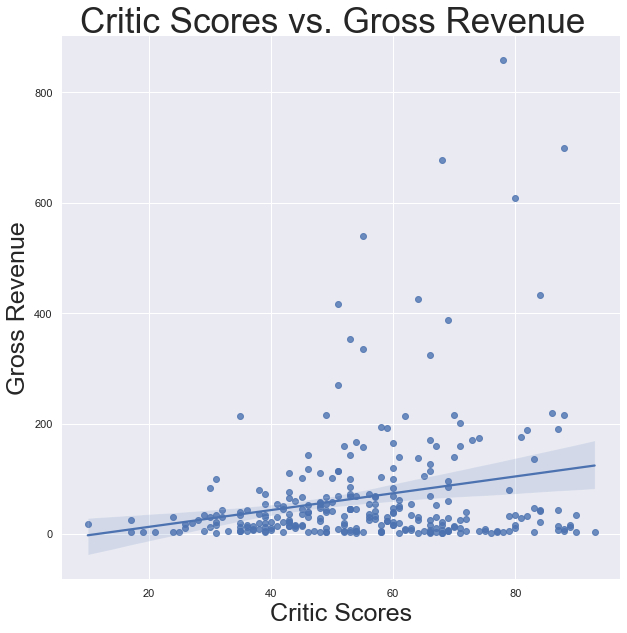

In [471]:
#graph critic scores vs. gross revenue
f, ax = plt.subplots(figsize=(10, 10))
sns.despine (f, left=True, bottom =True)

fig = sns.regplot(x=moviedf['metascore'], y=moviedf['gross'], data=moviedf, truncate=True)
fig.figure.suptitle('Critic Scores vs. Gross Revenue', y=0.92,fontsize = 35)
fig.set(xlabel='Critic Scores', ylabel='Gross Revenue')
plt.rcParams["axes.labelsize"] = 25

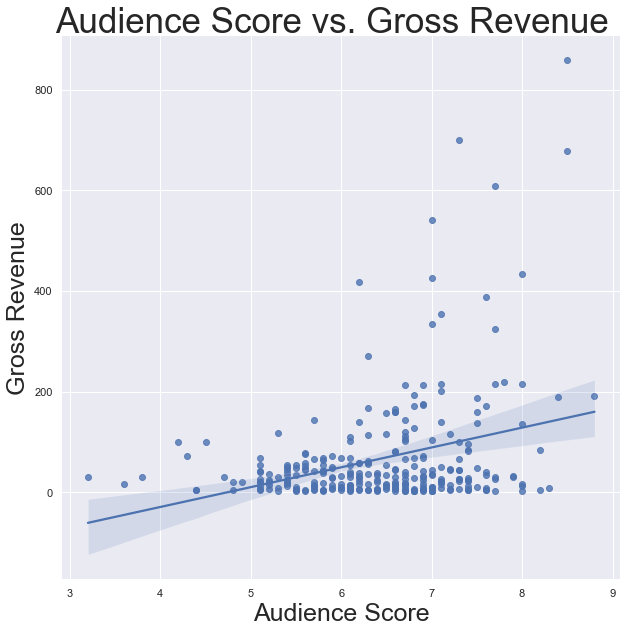

In [470]:
#graph audience score vs. gross revenue
f, ax = plt.subplots(figsize=(10, 10))
sns.despine (f, left=True, bottom =True)

fig = sns.regplot(x=moviedf['star_rating'], y=moviedf['gross'], data=moviedf, truncate=True)
fig.figure.suptitle('Audience Score vs. Gross Revenue', y=0.92,fontsize = 35)
fig.set(xlabel='Audience Score', ylabel='Gross Revenue')
plt.rcParams["axes.labelsize"] = 25

In [454]:
#get dataframe of drama movies only
dramadf = moviedf.drop(moviedf[moviedf.genre != 'Drama'].index)

In [455]:
#calculate correlation coefficients
dramadf.corr()

,year,star_rating,metascore,gross
year,1.000000,0.057010,-0.018534,0.102035
star_rating,0.057010,1.000000,0.703100,0.236511
metascore,-0.018534,0.703100,1.000000,0.272745
gross,0.102035,0.236511,0.272745,1.000000


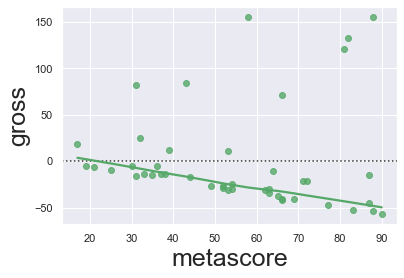

In [456]:
#plot residuals of metascore vs. gross
sns.residplot(x=dramadf['metascore'], y=dramadf['gross'], lowess=True, color="g")

In [457]:
#get dataframe of action movies only
actiondf = moviedf.drop(moviedf[moviedf.genre != 'Action'].index)

In [458]:
#calculate correlation coefficients
actiondf.corr()

,year,star_rating,metascore,gross
year,1.000000,0.136812,0.019405,0.069728
star_rating,0.136812,1.000000,0.677370,0.615359
metascore,0.019405,0.677370,1.000000,0.557501
gross,0.069728,0.615359,0.557501,1.000000


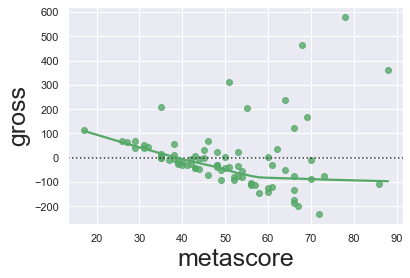

In [459]:
#plot residuals of metascore vs. gross
sns.residplot(x=actiondf['metascore'], y=actiondf['gross'], lowess=True, color="g")

In [460]:
#get dataframe of action movies only
animationdf = moviedf.drop(moviedf[moviedf.genre != 'Animation'].index)

In [461]:
#calculate correlation coefficients
animationdf.corr()

,year,star_rating,metascore,gross
year,1.000000,-0.120656,-0.187472,-0.019112
star_rating,-0.120656,1.000000,0.815481,0.350652
metascore,-0.187472,0.815481,1.000000,0.350106
gross,-0.019112,0.350652,0.350106,1.000000


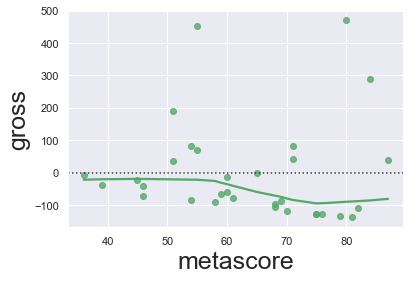

In [410]:
#plot residuals of metascore vs. gross
sns.residplot(x=animationdf['metascore'], y=animationdf['gross'], lowess=True, color="g")

In [465]:
#get dataframe of adventure movies only
adventuredf = moviedf.drop(moviedf[moviedf.genre != 'Adventure'].index)

In [466]:
#calculate correlation coefficients
adventuredf.corr()

,year,star_rating,metascore,gross
year,1.000000,0.330005,0.067240,0.165460
star_rating,0.330005,1.000000,0.624266,0.135122
metascore,0.067240,0.624266,1.000000,-0.115592
gross,0.165460,0.135122,-0.115592,1.000000


In [467]:
#get dataframe of adventure movies only
biographydf = moviedf.drop(moviedf[moviedf.genre != 'Biography'].index)

In [468]:
#calculate correlation coefficients
biographydf.corr()

,year,star_rating,metascore,gross
year,1.000000,-0.016149,-0.262982,0.016707
star_rating,-0.016149,1.000000,0.621742,0.486196
metascore,-0.262982,0.621742,1.000000,-0.055066
gross,0.016707,0.486196,-0.055066,1.000000


In [462]:
#get dataframe of adventure movies only
horrordf = moviedf.drop(moviedf[moviedf.genre != 'Horror'].index)

In [463]:
#calculate correlation coefficients
horrordf.corr()

,year,star_rating,metascore,gross
year,1.000000,0.400838,0.327233,-0.111512
star_rating,0.400838,1.000000,0.691101,0.288625
metascore,0.327233,0.691101,1.000000,0.571684
gross,-0.111512,0.288625,0.571684,1.000000


[Text(0, 0, 'Action'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Biography'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Documentary'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Horror')]

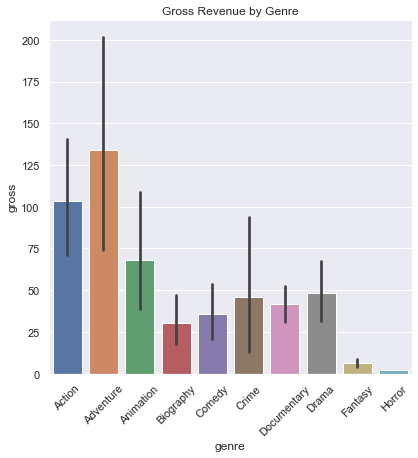

In [426]:
#set seaborn styling
sns.set(style="darkgrid")

#create plot of total Gross Revenue by Genre
sf, ax = plt.subplots(figsize=(6.5, 6.5))

bygenre = sns.barplot(x=moviedf['genre'], y=moviedf['gross'])
bygenre.set_title('Gross Revenue by Genre')
bygenre.set_xticklabels(gross_plotted.get_xticklabels(),rotation=45)

In [427]:
#create dataframe of the average gross revenue grouped by genre
gross_mean = pd.DataFrame(moviedf.groupby('genre')['gross'].mean()).reset_index()

Text(0.5, 1.0, 'Average Gross Revenue by Genre')

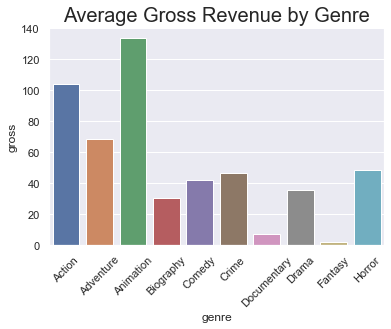

In [428]:
#plot average gross revenue by genre
gross_plotted = sns.barplot(x=gross_mean['genre'], y=gross_mean['gross'])
gross_plotted.set_xticklabels(gross_plotted.get_xticklabels(),rotation=45)
gross_plotted.set_title('Average Gross Revenue by Genre', fontsize=20)

In [429]:
#create dataframe of the median gross revenue grouped by genre
gross_median = pd.DataFrame(moviedf.groupby('genre')['gross'].median()).reset_index()

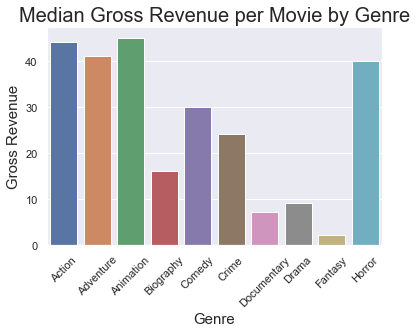

In [434]:
#plot median gross revenue by genre
gross_plotted = sns.barplot(x=gross_median['genre'], y=gross_median['gross'])
gross_plotted.set_xticklabels(gross_plotted.get_xticklabels(),rotation=45)
gross_plotted.set_title('Median Gross Revenue per Movie by Genre', fontsize=20)
gross_plotted.set(xlabel='Genre', ylabel='Gross Revenue')
plt.rcParams["axes.labelsize"] = 20

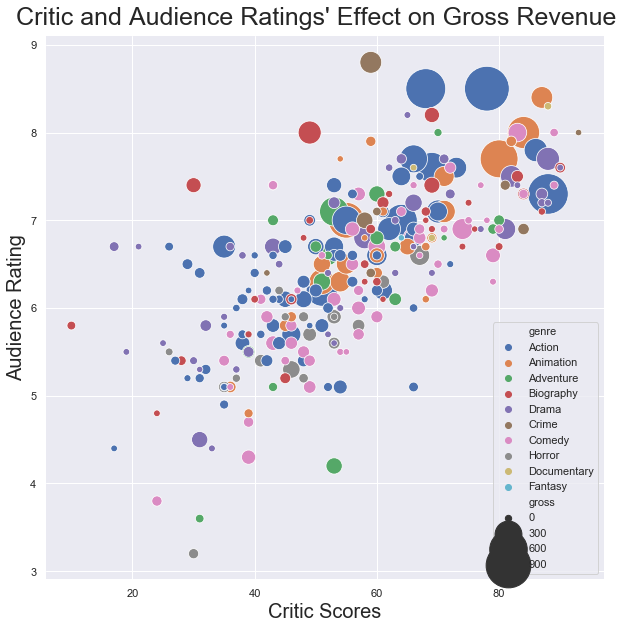

In [473]:
#plot critic ratings vs. audience ratings, with gross revenue size of bubble shown
f, ax = plt.subplots(figsize=(10, 10))
sns.despine (f, left=True, bottom =True)

fig = sns.scatterplot(x=moviedf['metascore'], y=moviedf['star_rating'], size = moviedf['gross'],sizes = (40,2000), hue = moviedf['genre'])
fig.figure.suptitle("Critic and Audience Ratings' Effect on Gross Revenue", y=0.92, fontsize = 25)
fig.set(xlabel='Critic Scores', ylabel='Audience Rating')
plt.rcParams["axes.labelsize"] = 20

In [7]:
#Import scores by Month of Movie Release
df5 = cursor.execute("""SELECT metascore, star_rating, release_date, EXTRACT(MONTH FROM release_date) FROM Movies.join_table""")
df5 = pd.DataFrame(cursor.fetchall())
df5.columns = [x[0] for x in cursor.description]


[Text(0, 0.5, 'Metascore'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Critic Rating by Release Month')]

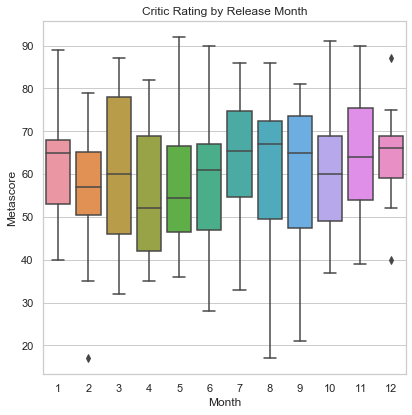

In [10]:
#Boxplot Metascores by Month Release
df5.drop(df5[df5.metascore == 0].index, inplace=True)
month_column = df5['EXTRACT(MONTH FROM release_date)']
df5.drop(df5[month_column == 0].index, inplace=True)
df5.head()

sns.set(style="whitegrid")

sf, ax = plt.subplots(figsize=(6.5, 6.5))
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
meta = sns.boxplot(x=df5['EXTRACT(MONTH FROM release_date)'], y=df5['metascore'])
meta.set(xlabel = "Month", ylabel='Metascore', title='Critic Rating by Release Month')

[Text(0, 0.5, 'Star Rating'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Audience Rating by Release Month')]

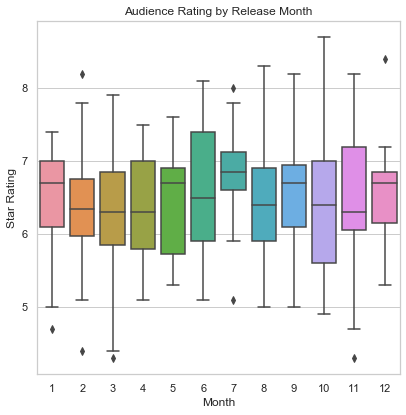

In [11]:
# BoxPlot Star Rating by Month Release
sns.set(style="whitegrid")

sf, ax = plt.subplots(figsize=(6.5, 6.5))

clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
d = sns.boxplot(x=df5['EXTRACT(MONTH FROM release_date)'], y=df5['star_rating'])
d.set(xlabel = "Month", ylabel='Star Rating', title='Audience Rating by Release Month')




In [12]:
#Import gross and release date
df6 = cursor.execute("""SELECT gross, year, release_date, EXTRACT(MONTH FROM release_date) FROM Movies.join_table""")
df6 = pd.DataFrame(cursor.fetchall())
df6.columns = [x[0] for x in cursor.description]

month_column = df6['EXTRACT(MONTH FROM release_date)']
df6.drop(df6[month_column == 0].index, inplace=True)

df6.head()

,gross,year,release_date,EXTRACT(MONTH FROM release_date)
0,85,2019,2019-01-31,1
1,140,2019,2019-03-23,3
2,54,2019,2019-04-04,4
3,30,2018,2018-04-19,4
4,0,2019,2019-07-18,7


[Text(0, 0.5, 'Gross(in Millions)'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Mean Gross by Release Month')]

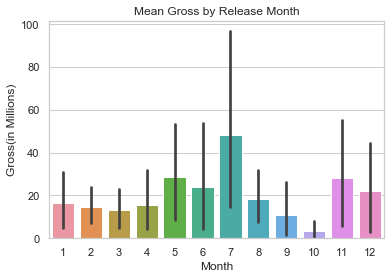

In [13]:
#Bar chart gross and release date
newplot = sns.barplot(x=df6['EXTRACT(MONTH FROM release_date)'], y=df6['gross'])
newplot.set_title(' Gross Revenue by Release Month')
newplot.set(xlabel = "Month", ylabel='Gross(in Millions)', title='Mean Gross by Release Month')



[Text(0, 0.5, 'Gross(in Millions)'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Mean Gross by Release Month')]

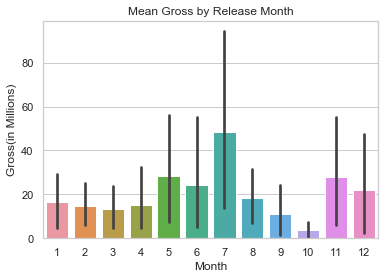

In [14]:
#Bar chart gross and release date
newplot = sns.barplot(x=df6['EXTRACT(MONTH FROM release_date)'], y=df6['gross'])
newplot.set_title(' Gross Revenue by Release Month')
newplot.set(xlabel = "Month", ylabel='Gross(in Millions)', title='Mean Gross by Release Month')

[Text(0, 0.5, 'Gross(in Millions)'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Gross Revenue by Release Month')]

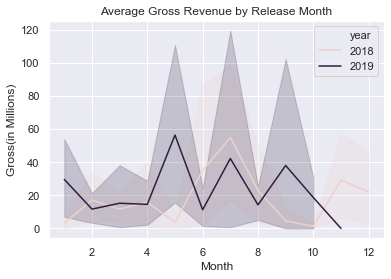

In [15]:
#Line plot 2018/2019 Gross by Release Date
month_column = df6['EXTRACT(MONTH FROM release_date)']
df6.drop(df6[month_column == 0].index, inplace=True)

sns.set(style="darkgrid")

#df8 = df6.groupby(['year','EXTRACT(MONTH FROM release_date)'])['gross'].mean()   

yearly_gross_plotted = sns.lineplot(x=df6['EXTRACT(MONTH FROM release_date)'], y=df6['gross'], hue=df6['year'], data=df6)
yearly_gross_plotted.set(xlabel = "Month", ylabel='Gross(in Millions)', title='Average Gross Revenue by Release Month')


/Users/cblessen/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


TypeError: set_xticklabels() missing 1 required positional argument: 'labels'

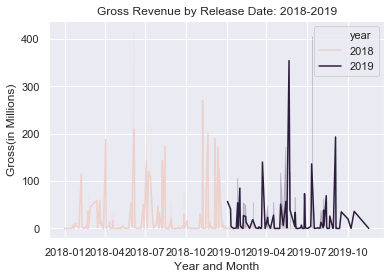

In [16]:
#Line plot over the full two years

two_yr_gross_plotted = sns.lineplot(x=df6['release_date'], y=df6['gross'], hue=df6['year'], color ='coolwarm',
             data=df6)
two_yr_gross_plotted.set(xlabel = "Year and Month", ylabel='Gross(in Millions)', title='Gross Revenue by Release Date: 2018-2019')
two_yr_gross_plotted.set_xticklabels(two_yr_gross_plotted.set_xticklabels(),rotation=45)

In [17]:
#Import Overviews
df10 = cursor.execute("""SELECT overview FROM Movies.join_table""")
df10 = pd.DataFrame(cursor.fetchall())
df10.columns = [x[0] for x in cursor.description]
list_of_overviews = df10.values.tolist()

list_of_overviews = [val[0] for val in list_of_overviews]

list_of_overviews[:5]

['When Alita awakens with no memory of who she is in',
 'A boy is given the ability to become an adult supe',
 'Dr. Louis Creed and his wife, Rachel, move from Bo',
 'When an international border dispute arises betwee',
 "The origin story behind one of Broadway's most bel"]

In [20]:
def most_words(data): 

    data2 = []
    for x in data:
         data2.append(x) 
    
    words = []
    for item in data2:
        words.extend(item.split())
    word_freq_dict = {}
    
    for word in words:
        if word not in word_freq_dict:
            word_freq_dict[word] = 1
        else:
            word_freq_dict[word] = word_freq_dict[word] + 1
    
    
    most_used_word = []

    for key, value in word_freq_dict.items():
        if value >= 5:
            most_used_word.append(key)
    
    return most_used_word

top_words = most_words(list_of_overviews)
top_words

['When',
 'with',
 'of',
 'who',
 'is',
 'in',
 'A',
 'boy',
 'the',
 'to',
 'an',
 'and',
 'his',
 'from',
 'The',
 'story',
 'one',
 'most',
 'by',
 'a',
 'about',
 'woman',
 'her',
 'Null',
 'f',
 'Based',
 'on',
 'young',
 'has',
 'love',
 'In',
 'takes',
 'life',
 'between',
 'at',
 'After',
 'that',
 'their',
 'years',
 'returns',
 'up',
 'into',
 'are',
 'lives',
 'street',
 'finds',
 'when',
 'for',
 'An',
 'world',
 'girl',
 'was',
 'home',
 'time',
 'they',
 'New',
 'after',
 'becomes',
 't',
 'family']